In [1]:
# To reload modified python modules
%load_ext autoreload
%autoreload 2

# Optimizing parameter spaces
In this notebook, we test the gradient descent code that finds:
1. An optimal coupling between distinct parameter spaces
2. An optimal weight on a shared parameter space

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

# Optimal transport
from ot.gromov import gromov_wasserstein
from utils.gw_ms import gromov_wasserstein_ms, compute_dGWs
from utils.gw_ms import gw_ms_couple_nu, gw_ms_learn_nu
from utils.utils import stepwise_pdist

# Graph functions
import networkx as nx

# Utilities
import time

from utils.classification_functions import *

# Coupling parameter spaces
I will generate one pm-net, then reverse the order. Hopefully the parameter coupling recognizes the reordering.

10


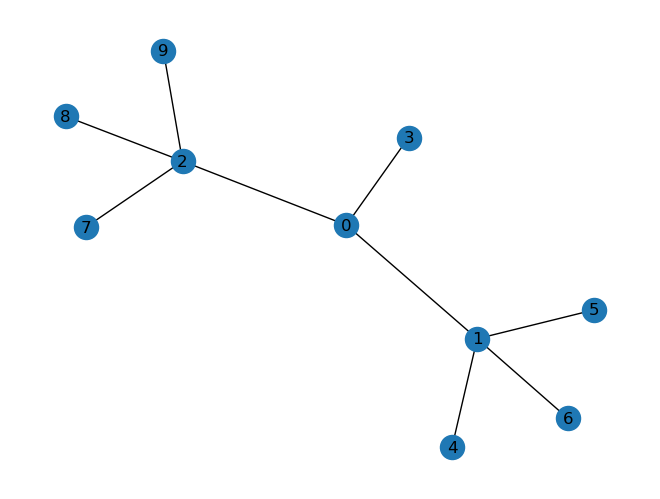

In [3]:
G = nx.full_rary_tree(3, 10)
print(G.number_of_nodes())

nx.draw(G, with_labels=True)

In [4]:
# Create a single multiscale network
N = 20
G1 = nx.cycle_graph(N)
G2 = nx.full_rary_tree(3, N)

# Obtain distance matrices
dm1 = nx.floyd_warshall_numpy(G1)
dm2 = nx.floyd_warshall_numpy(G2)

# Create multiscale sequences with different orders
lC1 = [dm1, dm2]
lC2 = [dm2, dm1]

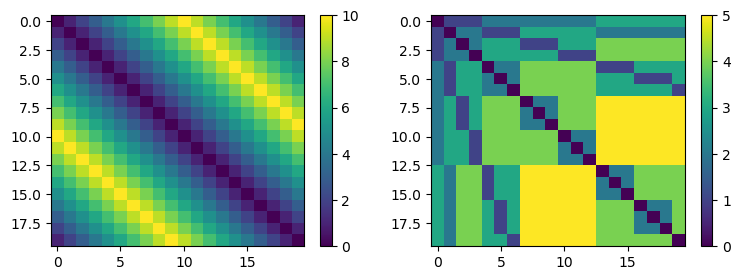

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
ims = [None] * 2

for i in range(2):
    im = axes[i].imshow(lC1[i], vmin=0, aspect="auto")
    plt.colorbar(im, ax=axes[i])

In [6]:
# nu1 = unif(2)
nu1 = np.array([0.7, 0.3])
nu2 = np.flip(nu1)
# nu2 = nu1
T, E, log, logE, logG = gw_ms_couple_nu(
    lC1, lC2, nu1=nu1, nu2=nu2, log=True, verbose=True
)
print()

print(f"The distance between the sequnces is: {log['loss'][-1]}")

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.452630e+01|0.000000e+00|0.000000e+00
    1|-2.646772e-15|5.488309e+15|1.452630e+01
    2|-2.646772e-15|0.000000e+00|0.000000e+00

The distance between the sequnces is: -2.646771690706373e-15


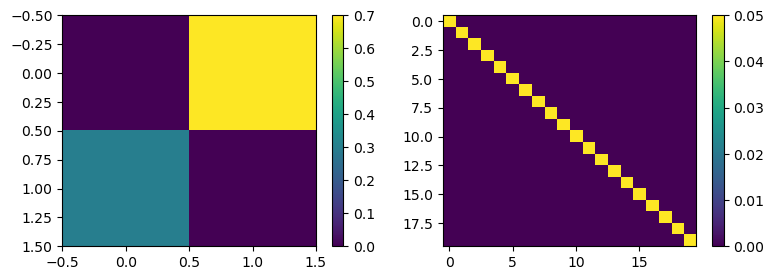

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
ims = [None] * 2
ims[0] = axes[0].imshow(E, vmin=0, aspect="auto")
ims[1] = axes[1].imshow(T, vmin=0, aspect="auto")

for i in range(2):
    plt.colorbar(ims[i], ax=axes[i])

# Metric learning -- dynamic metric spaces
In this setting, I have a shared parameter space with unknown weights, for example, dynamic metric spaces where the parameter space is time. We want to learn the weights on the parameter space that minimize the classification error of the parametrized GW distance.

## Experiment

In [8]:
# Data and arena parameters
shape = (5, 5)
nSteps = 5
dx = 0.6
room_length = nSteps * dx

# Number of instances in each class
n_copies = 5

# Noise
rng = np.random.default_rng(304)
std = 0.05

# Obstacle parameters
obstacles = [
    {"center": None, "radii": None},
    {"center": (1.5, 0), "radii": (0.5, 0.7)},
    # {'center': (1.0, 0), 'radii': (0.5,0.7)},
    # {'center': (3.0, 0), 'radii': (0.5,0.7)},
]
n_classes = len(obstacles)

# Create obstacle function for each set of parameters
# and store
for i in range(len(obstacles)):
    # Create obstacle function
    params = obstacles[i]
    obstacle = create_obstacle_fun(**params)

    # Store
    params["obstacle"] = obstacle
    obstacles[i] = params

In [9]:
# Base sequences
seqs_0 = []
for params in obstacles:
    seq = moving_point_grid(shape, dx, nSteps, params["obstacle"])
    seqs_0.append(seq)

# ---------------------------------------------
# Part 1: Generate graphs and their invariants
# ---------------------------------------------
seqs_all = []
lCs_all = []  # Store lCs as a big list

for idc in range(n_classes):
    seqs_class = []
    lCs_class = []

    params = obstacles[idc]
    center = params["center"]
    radii = params["radii"]
    obstacle = params["obstacle"]

    # Sample several instances
    for j in range(n_copies):
        P_seq = seqs_0[idc].copy()

        # Add noise and compute distances
        for t in range(nSteps):
            P_seq[t, :, :] = add_noise_avoid_obstacle(
                P_seq[t, :, :], std, center, obstacle, rng=rng
            )

            H = stepwise_pdist(P_seq)

        # Accumulate one instance
        seqs_class.append(P_seq)
        lCs_class.append(H)

    # Accumulate all instances of the class
    seqs_all.append(np.array(seqs_class))
    lCs_all.extend(lCs_class)

In [10]:
# Create class labels, and obtain cost functions
N = len(lCs_all)

y_true = np.repeat(np.arange(n_classes), n_copies).astype(int)
Is = np.reshape(np.arange(N), (n_classes, -1)).astype(int)

S, dS = S_multi_class_fixed(Is, N)

print("Num. sequences:", N)
print("True labels:")
print(y_true)
print()

print("Classes:")
print(Is)

Num. sequences: 10
True labels:
[0 0 0 0 0 1 1 1 1 1]

Classes:
[[0 1 2 3 4]
 [5 6 7 8 9]]


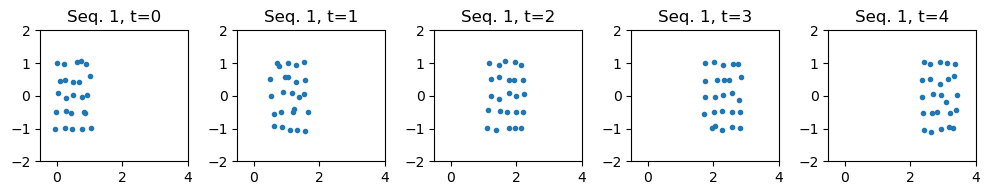

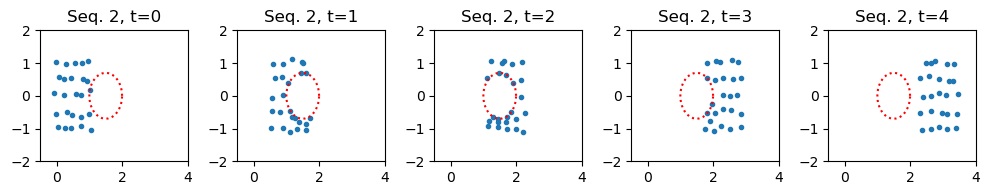

In [11]:
# Plot first element of each class
for idc in range(n_classes):
    seq = seqs_all[idc][0, :, :]

    params = obstacles[idc]
    center = params["center"]
    radii = params["radii"]

    if center is None or radii is None:
        plot_obstacle = False
    else:
        plot_obstacle = True

    fig, ax = plot_drone_grid(
        seq, room_length, center, radii, plot_obstacle=plot_obstacle, seq_id=idc + 1
    )
    # plt.savefig(f'../output/paper/Drone_seq_{idc+1}.pdf', bbox_inches='tight')

 -------------------------- 
Regularization: 10**(-3)


0
Score: 0.284783

1
Score: 0.272864

2
Score: 0.207381

3
Score: 0.363906

4
Score: 0.432409

Metric learning:
[6.683e-17 0.000e+00 1.000e+00 4.821e-17 2.514e-17]
Score: 0.207381


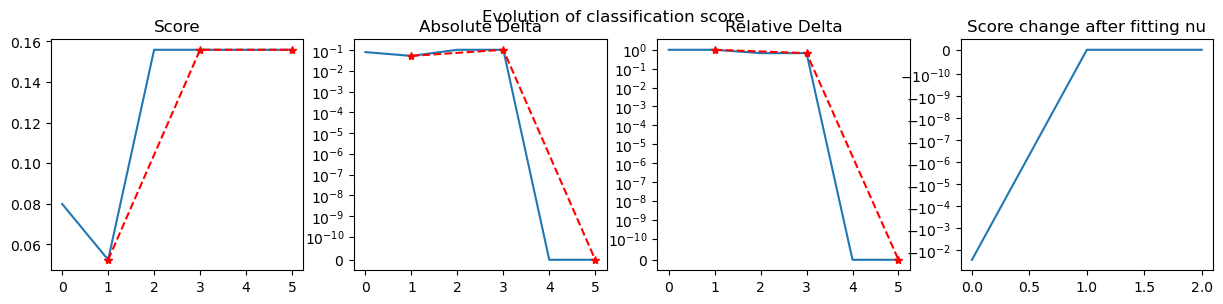

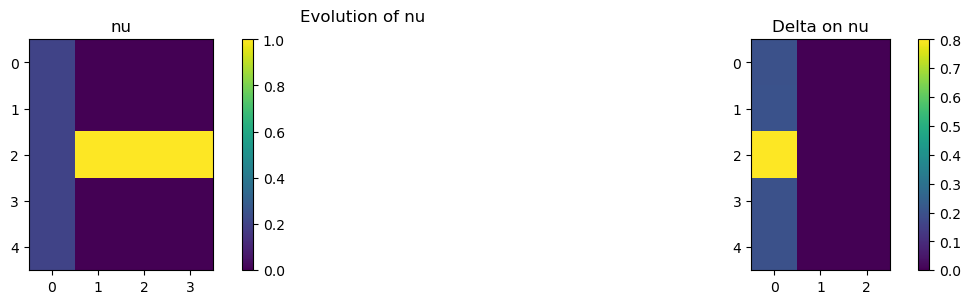

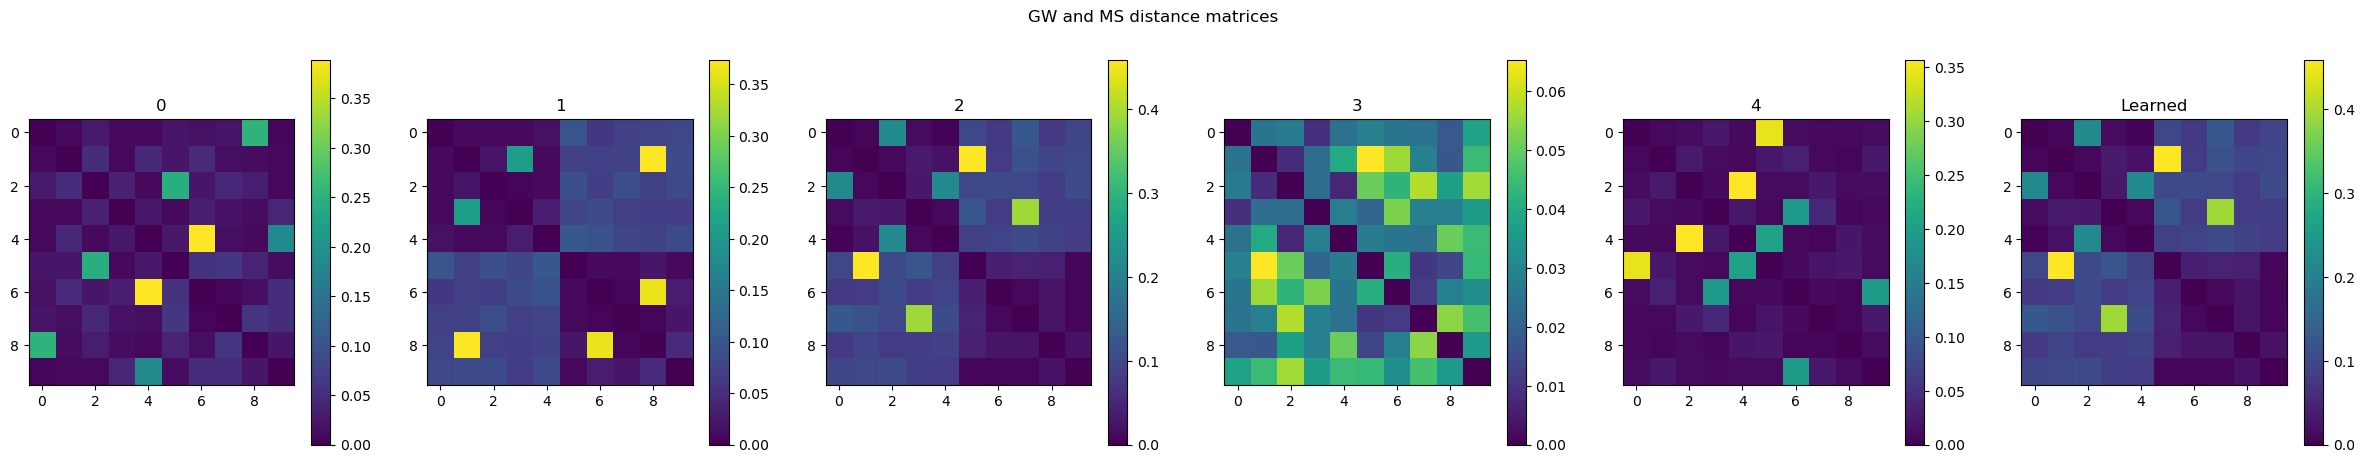


 -------------------------- 
Regularization: 10**(-2)


0
Score: 0.284783

1
Score: 0.272864

2
Score: 0.207381

3
Score: 0.363906

4
Score: 0.432409

Metric learning:
[1.554e-04 3.087e-03 9.951e-01 1.321e-03 3.060e-04]
Score: 0.218000


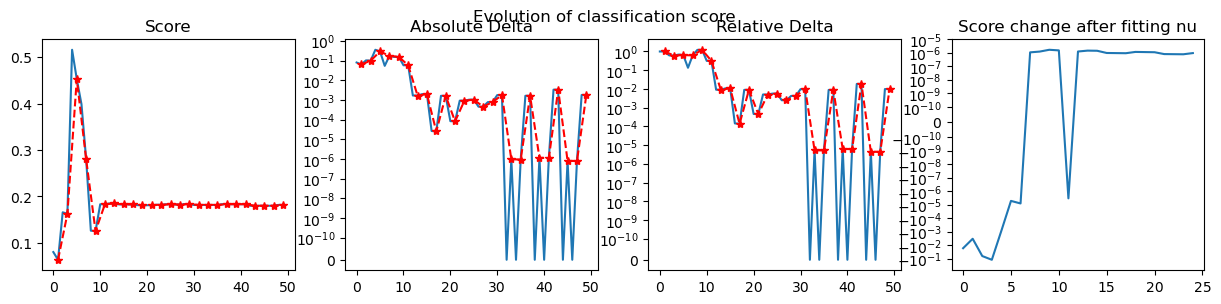

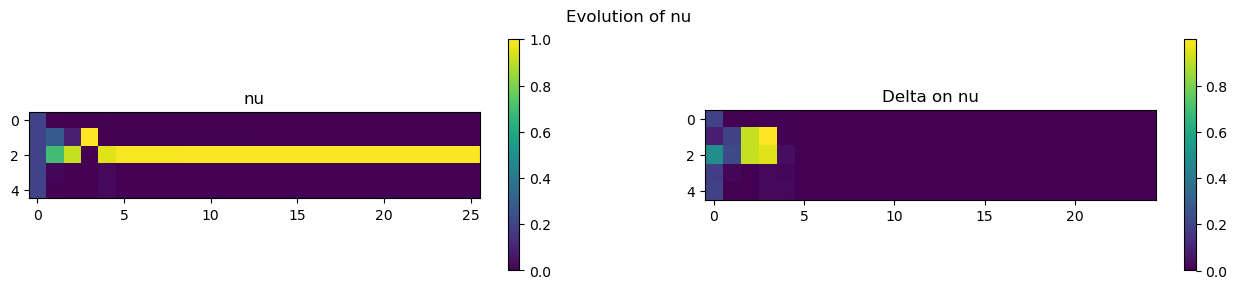

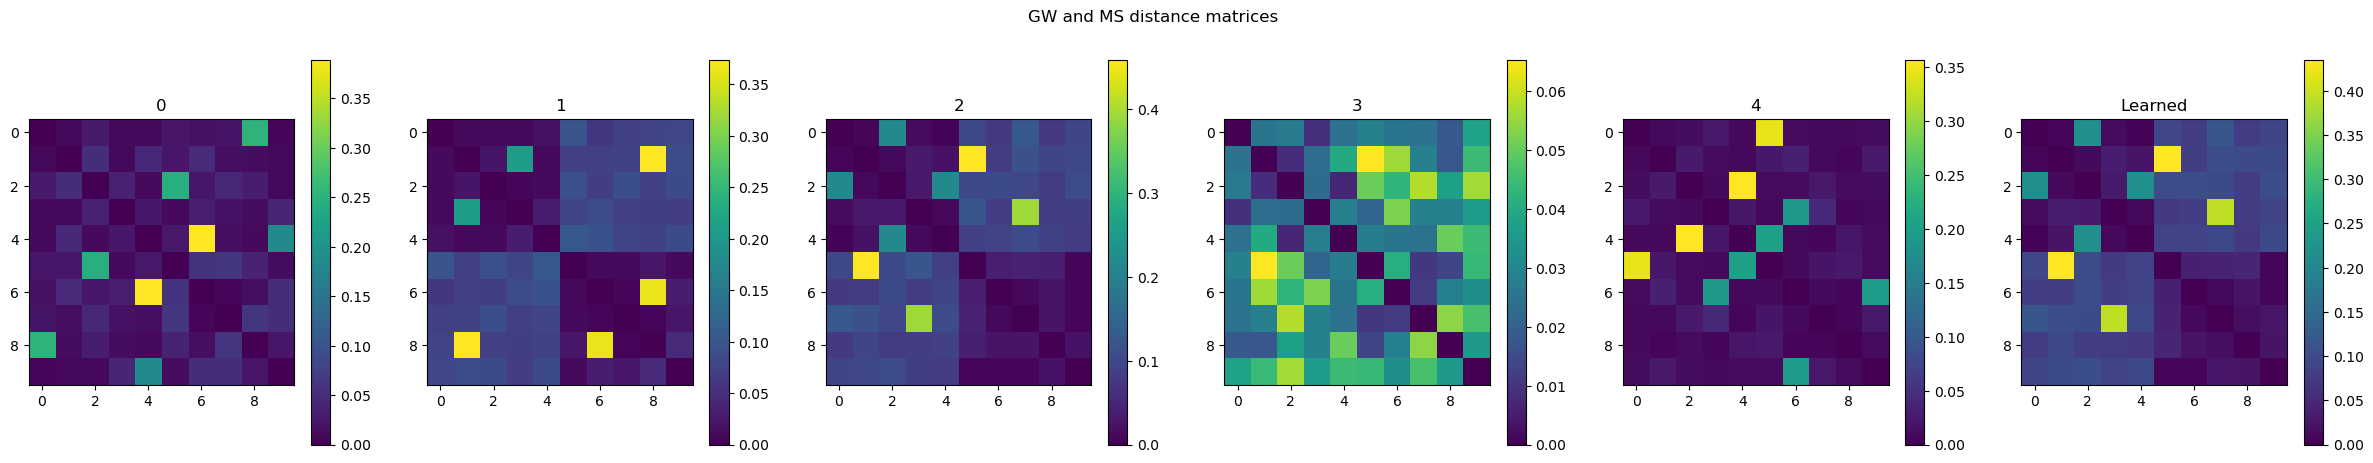


 -------------------------- 
Regularization: 10**(-1)


0
Score: 0.284783

1
Score: 0.272864

2
Score: 0.207381

3
Score: 0.363906

4
Score: 0.432409

Metric learning:
[0.02  0.307 0.623 0.026 0.024]
Score: 0.272901


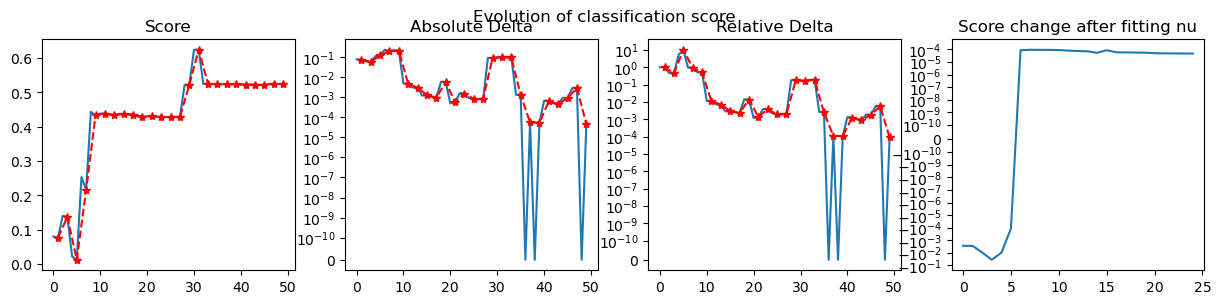

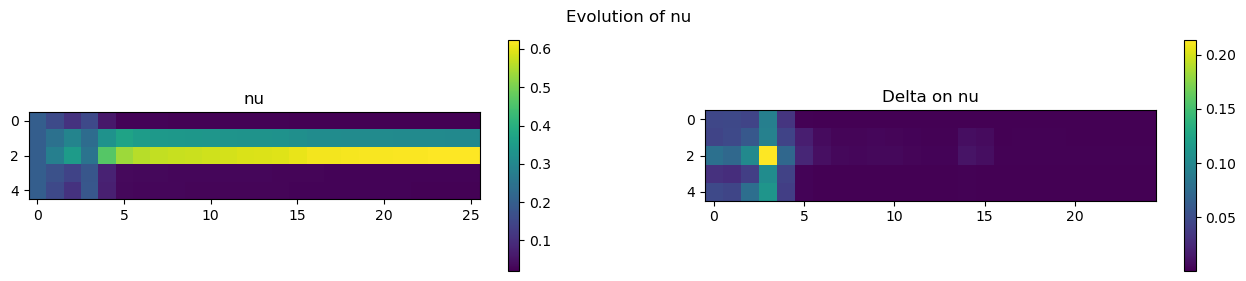

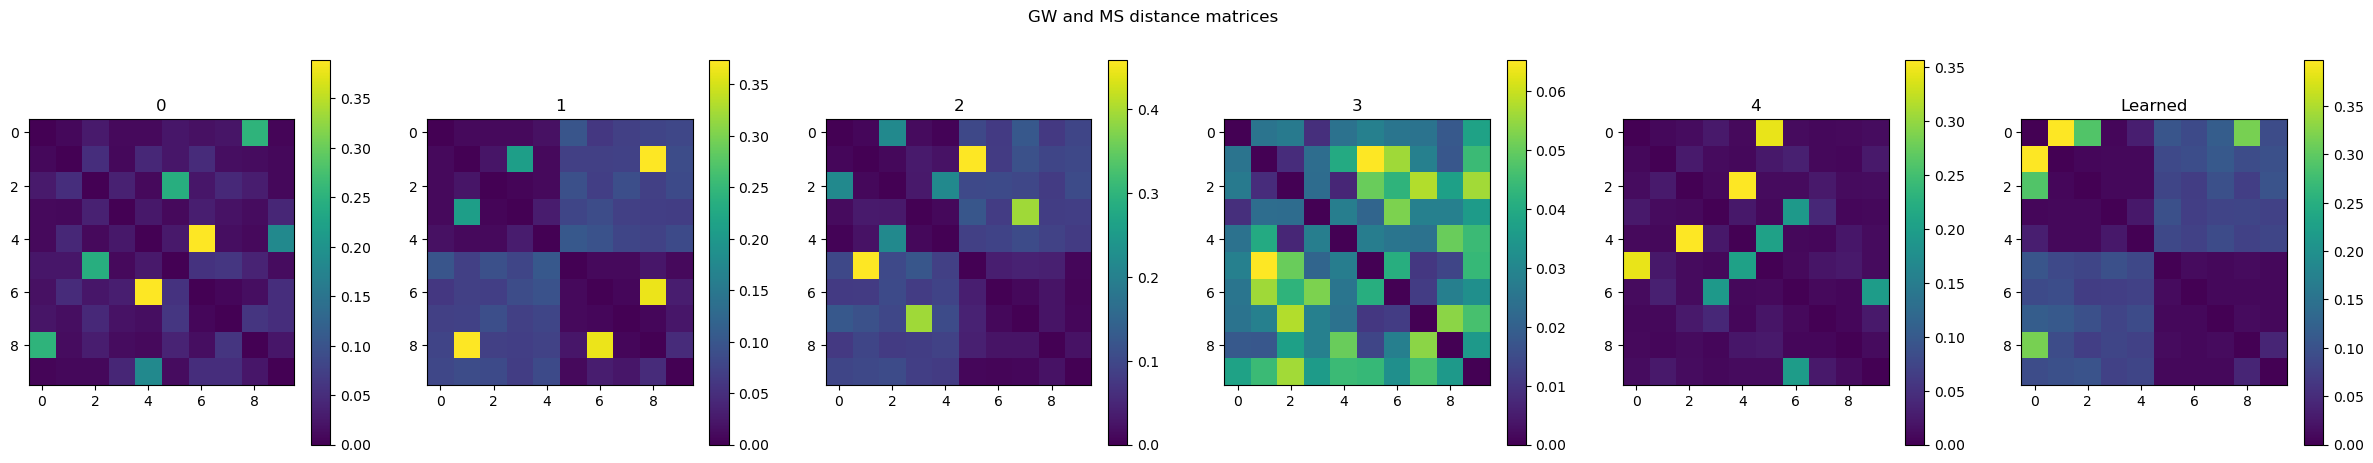


 -------------------------- 
Regularization: 10**(0)


0
Score: 0.284783

1
Score: 0.272864

2
Score: 0.207381

3
Score: 0.363906

4
Score: 0.432409

Metric learning:
[0.182 0.217 0.231 0.189 0.181]
Score: 0.249019


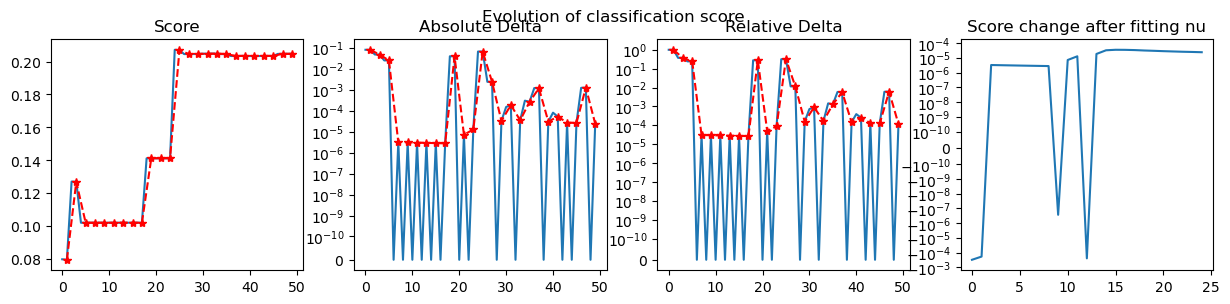

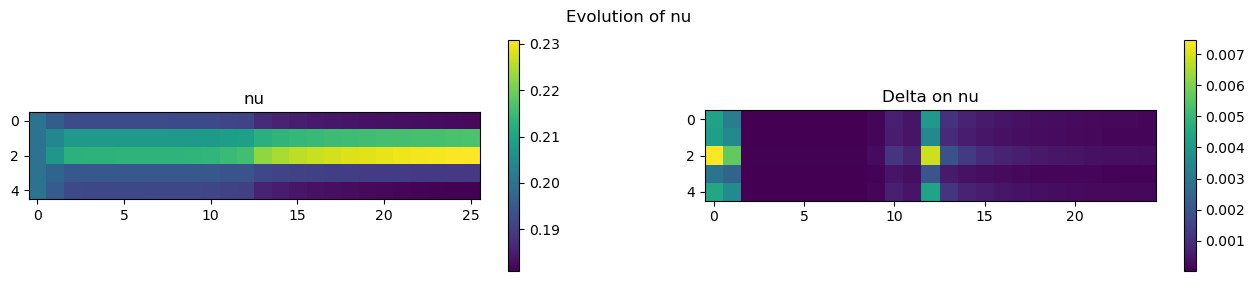

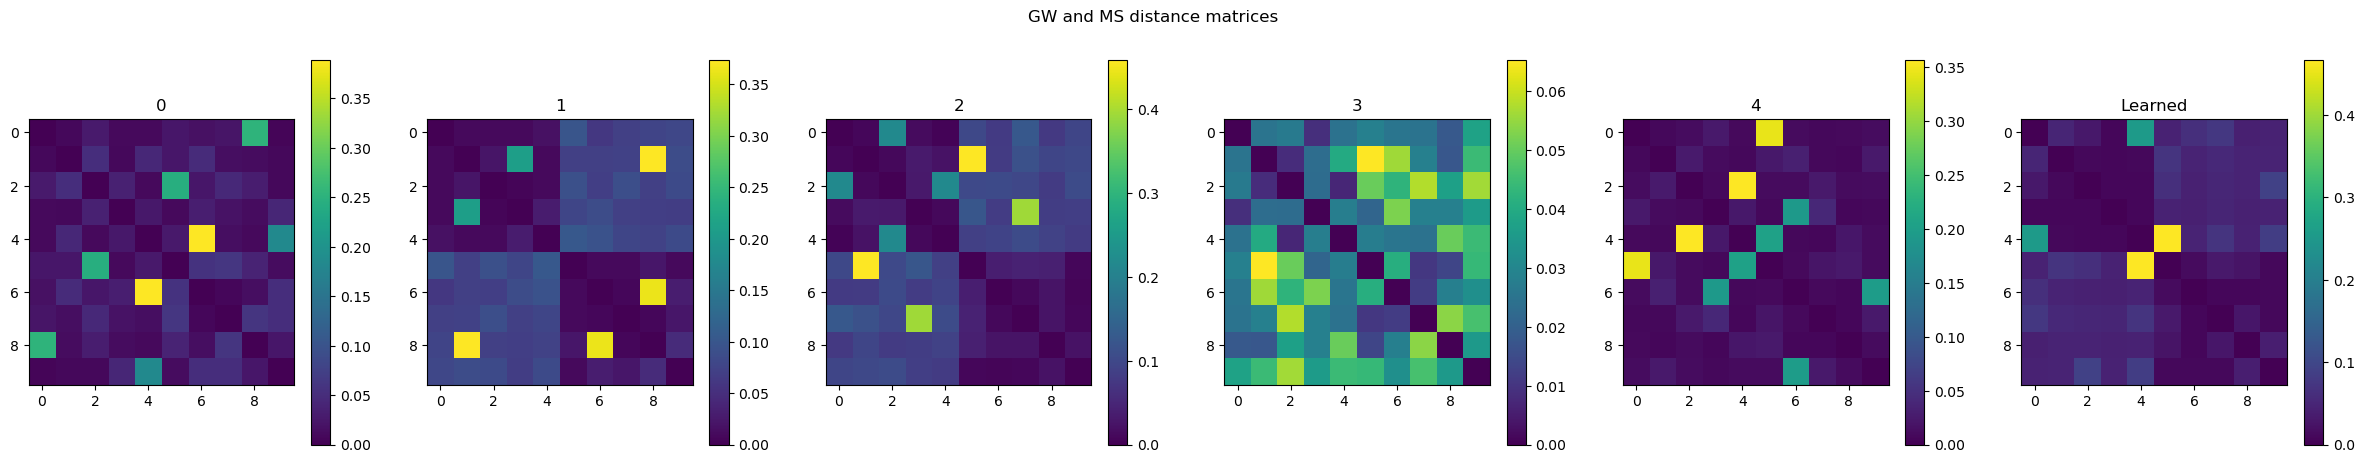


 -------------------------- 
Regularization: 10**(1)


0
Score: 0.284783

1
Score: 0.272864

2
Score: 0.207381

3
Score: 0.363906

4
Score: 0.432409

Metric learning:
[0.199 0.201 0.201 0.2   0.199]
Score: 0.160706


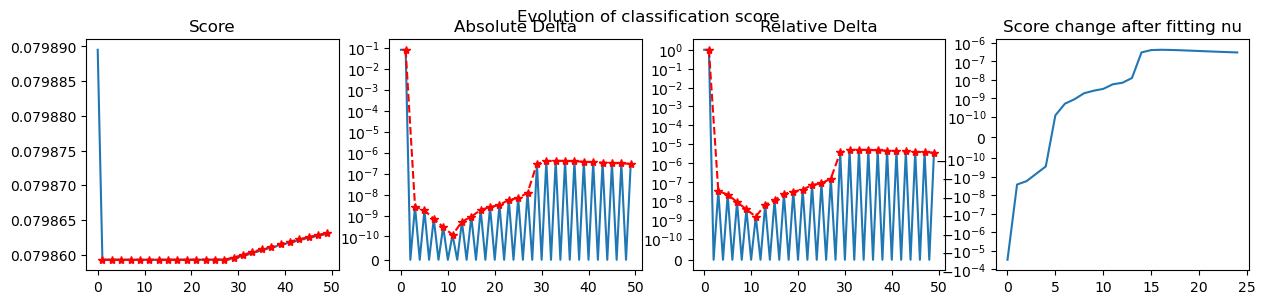

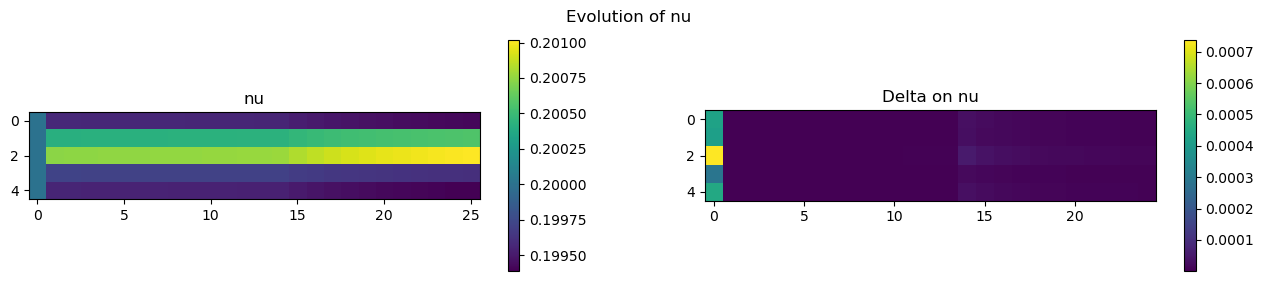

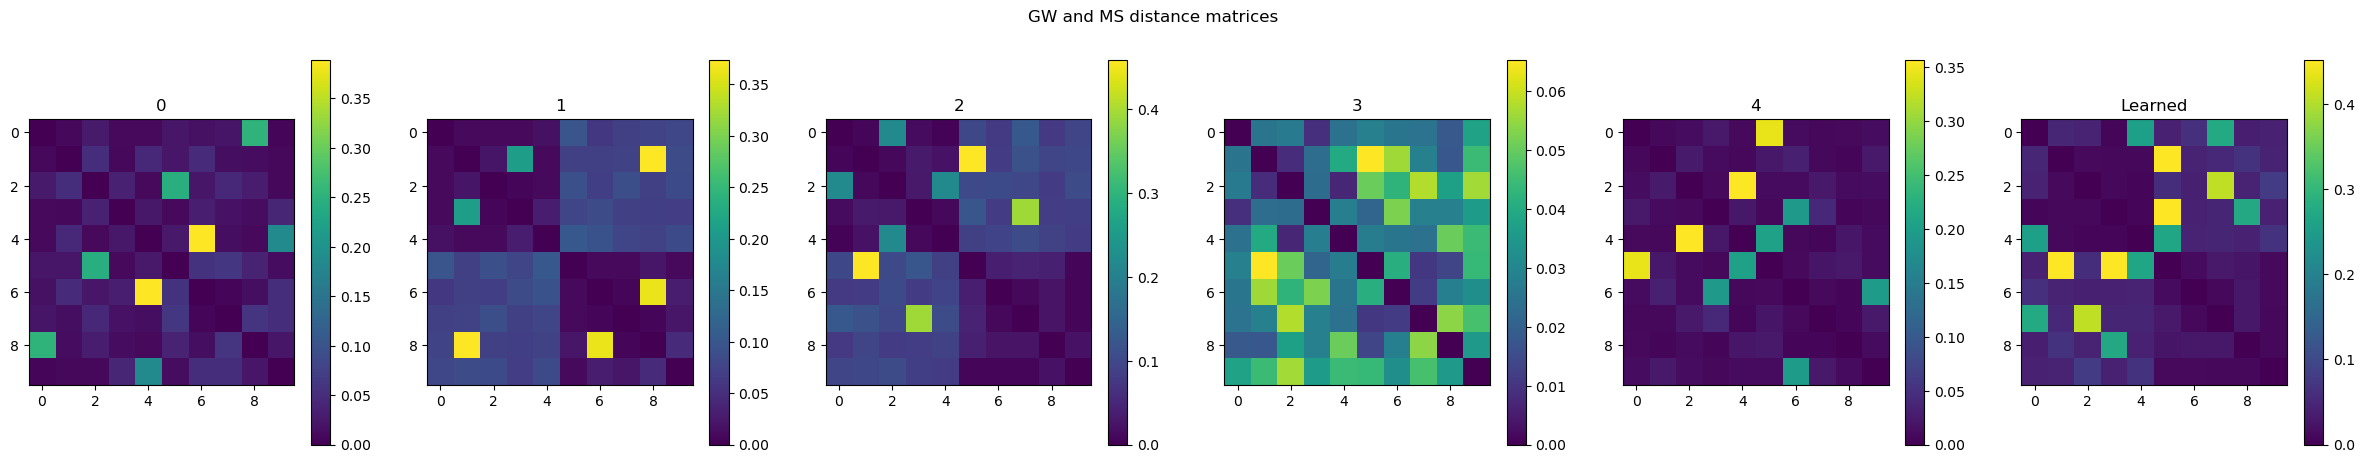

In [12]:
exponents = np.arange(-3, 2).astype(int)
max_iter = 25

for exp in exponents:
    print(" -------------------------- ")
    print(f"Regularization: 10**({exp})")
    print()

    # ---------------------------------------------
    # Part 2: Compute distances
    # ---------------------------------------------
    dGWs = compute_dGWs(nSteps, lCs_all, verbose=0)

    # Compute dMS and learn weights
    lambda_S = 10.0 ** (exp)
    time_start = time.time()
    dMSs, Ts, nu, score, info = gw_ms_learn_nu(
        lCs_all,
        S=S,
        dS=dS,
        lambda_S=lambda_S,
        loss_fun="square_loss",
        verbose=0,
        max_iter=max_iter,
        tol_rel=1e-15,
        tol_abs=1e-15,
    )
    score_list, abs_delta_list, rel_delta_list, nu_list = info
    time_end = time.time()
    dt = time_end - time_start

    dMSs = np.maximum(dMSs, 0)

    # ---------------------------------------------
    # Part 3: Output
    # ---------------------------------------------
    fig1, axes1, fig2, axes2 = plot_score_and_deltas(
        score_list, abs_delta_list, rel_delta_list, nu_list
    )

    invariant_names = np.arange(nSteps).tolist()
    fig3, axes3, im3 = MS_output(dGWs, dMSs, nu, nSteps, S, invariant_names)
    plt.show()

    # print("Metric learning:")
    # print(nu)
    # print("Score: {:3f}".format(S(dMSs, p=1)))

    # fig4, ax4 = show_couplings(Ts)
    print()

## Supervised clustering

In [13]:
# Data and arena parameters
shape = (5, 5)
nSteps = 5
dx = 0.6
room_length = nSteps * dx

# Number of instances in each class
n_neighbor_list = [1, 3]
n_params = len(n_neighbor_list)

# Noise
rng = np.random.default_rng(304)
std = 0.05

# Optimization parameters
lambda_S = 1e-1
max_iter = 10

# Obstacle parameters
obstacles = [
    {"center": None, "radii": None},
    {"center": (1.5, 0), "radii": (0.5, 0.7)},
    # {'center': (1.0, 0), 'radii': (0.5,0.7)},
    # {'center': (3.0, 0), 'radii': (0.5,0.7)},
]
n_classes = len(obstacles)

# Create obstacle function for each set of parameters
# and store
for i in range(len(obstacles)):
    # Create obstacle function
    params = obstacles[i]
    obstacle = create_obstacle_fun(**params)

    # Store
    params["obstacle"] = obstacle
    obstacles[i] = params

In [14]:
nReps = 20

copies_train = 30
copies_test = 20
n_copies = copies_train + copies_test

I_train = np.arange(copies_train).astype(int)
I_test = np.arange(copies_train, n_copies).astype(int)

In [15]:
# Base sequences
seqs_0 = []
for params in obstacles:
    seq = moving_point_grid(shape, dx, nSteps, params["obstacle"])
    seqs_0.append(seq)

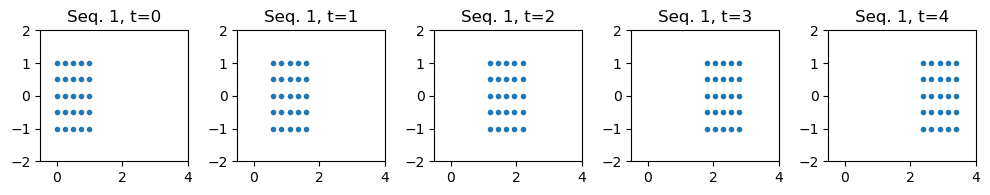

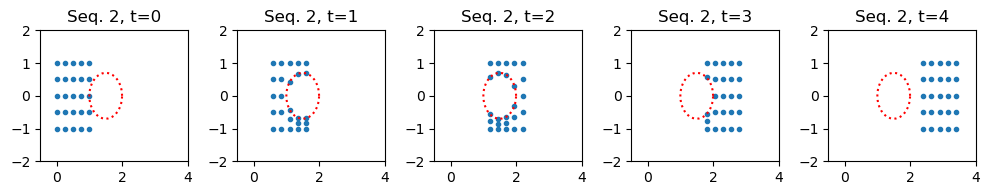

In [16]:
for idc in range(n_classes):
    seq = seqs_0[idc]

    params = obstacles[idc]
    center = params["center"]
    radii = params["radii"]

    if center is None or radii is None:
        plot_obstacle = False
    else:
        plot_obstacle = True

    fig, ax = plot_drone_grid(
        seq, room_length, center, radii, plot_obstacle=plot_obstacle, seq_id=idc + 1
    )

In [17]:
accuracies = np.zeros((n_params, nReps, nSteps))
accuracies_2 = np.zeros((n_params, nReps))
accuracies_ms = np.zeros((n_params, nReps))
accuracies_hard = np.zeros((n_params, nReps))
accuracies_soft = np.zeros((n_params, nReps))

for i in range(nReps):
    rep_start = time.time()

    # ---------------------------------------------
    # Part 1: Generate graphs and their invariants
    # ---------------------------------------------
    seqs_all = []
    lCs_all = []

    for idc in range(n_classes):
        seqs_class = []
        lCs_class = []

        params = obstacles[idc]
        center = params["center"]
        radii = params["radii"]
        obstacle = params["obstacle"]

        # Sample several instances
        for j in range(n_copies):
            P_seq = seqs_0[idc].copy()

            # Add noise and compute distances
            for t in range(nSteps):
                P_seq[t, :, :] = add_noise_avoid_obstacle(
                    P_seq[t, :, :], std, center, obstacle, rng=rng
                )

                H = stepwise_pdist(P_seq)

            # Accumulate one instance
            seqs_class.append(P_seq)
            lCs_class.append(H)

        # Accumulate all instances of the class
        seqs_all.append(np.array(seqs_class))
        lCs_all.append(np.array(lCs_class))

    # Separating training and test sets
    # --------------------
    N = np.sum([lC.shape[0] for lC in lCs_all])

    # Train set
    seqs_train = np.concatenate(
        [seq_class[I_train, :, :] for seq_class in seqs_all], axis=0
    )
    lCs_train = np.concatenate(
        [lCs_class[I_train, :, :] for lCs_class in lCs_all], axis=0
    )

    n_train = seqs_train.shape[0]
    y_train = np.repeat(np.arange(n_classes), copies_train).astype(int)
    Is_train = np.reshape(np.arange(n_train), (n_classes, -1)).astype(int)
    S_train, dS_train = S_multi_class_fixed(Is_train, n_train)

    # Test set
    seqs_test = np.concatenate(
        [seq_class[I_test, :, :] for seq_class in seqs_all], axis=0
    )
    lCs_test = np.concatenate(
        [lCs_class[I_test, :, :] for lCs_class in lCs_all], axis=0
    )

    n_test = seqs_test.shape[0]
    y_test = np.repeat(np.arange(n_classes), copies_test).astype(int)
    Is_test = np.reshape(np.arange(n_test), (n_classes, -1)).astype(int)
    S_test, dS_test = S_multi_class_fixed(Is_test, n_test)

    # ---------------------------------------------
    # Part 2: GW distance benchmark
    # ---------------------------------------------
    dGWs_train = compute_dGWs(nSteps, lCs_train, verbose=0)

    # Compute GW and MS distances between the test set and all the train set
    # Since we already have nu, we use a fixed parameter set and fixed measure
    dGWs_test = np.zeros((nSteps, n_test, n_train))
    for i_test in range(n_test):
        lC_test = lCs_test[i_test]
        for i_train in range(n_train):
            lC_train = lCs_train[i_train]

            # GW between individual invariants
            for t in range(nSteps):
                time_start = time.time()
                _, log = gromov_wasserstein(
                    lC_test[t, :, :], lC_train[t, :, :], log=True
                )
                time_end = time.time()

                dGWs_test[t, i_test, i_train] = log["gw_dist"]

    # ---------------------------------------------
    # Part 3: Compute MS distance and learn nu
    # ---------------------------------------------
    # Compute dMS and learn weights
    time_start = time.time()
    dMSs_train, Ts_train, nu_trained, score, info = gw_ms_learn_nu(
        lCs_train,
        S=S_train,
        dS=dS_train,
        lambda_S=lambda_S,
        loss_fun="square_loss",
        verbose=0,
        max_iter=max_iter,
        tol_rel=1e-12,
        tol_abs=1e-12,
    )
    score_list, abs_delta_list, rel_delta_list, nu_list = info
    time_end = time.time()
    dt = time_end - time_start

    dMSs_train = np.maximum(dMSs_train, 0)

    print("nu_trained")
    print(nu_trained)
    print()

    # ---------------------------------------------
    # Part 4: Compute distances on test set
    # ---------------------------------------------
    # Compute GW and MS distances between the test set and all the train set
    # Since we already have nu, we use a fixed parameter set and fixed measure
    dMSs_test = np.zeros((n_test, n_train))

    for i_test in range(n_test):
        lC_test = lCs_test[i_test]
        for i_train in range(n_train):
            lC_train = lCs_train[i_train]

            # MS with pre-trained weights
            time_start = time.time()
            _, log = gromov_wasserstein_ms(
                lC_test, lC_train, nu=nu_trained, log=True, verbose=0
            )
            time_end = time.time()

            dMSs_test[i_test, i_train] = log["gw_dist"]

    # ---------------------------------------------
    # Part 5: Classification experiment
    # ---------------------------------------------
    for idn, n_neighbors in enumerate(n_neighbor_list):
        (
            pred_probs,
            accuracy,
            accuracy_ms,
            accuracy_hard,
            accuracy_soft,
        ) = classification_experiment(
            n_neighbors,
            n_classes,
            (dGWs_train, dMSs_train, y_train),
            (dGWs_test, dMSs_test, y_test),
        )
        # ---------------------------------------------
        # Part 6: Ensemble of the best classifiers
        # ---------------------------------------------
        # Select only the best classifiers
        pred_probs = pred_probs[[2, 4], :, :]
        accuracy_2 = np.zeros(2)

        # Create ensemble
        max_probs = np.max(pred_probs, axis=2)
        winners = pred_probs == max_probs[:, :, None]

        votes = np.sum(winners, axis=0)
        y_pred_hard = votes.argmax(axis=1)

        # Rescale accuracies
        accuracies[idn, i, :] = 100 * accuracy
        accuracies_2[idn, i] = 100 * accuracy_score(y_test, y_pred_hard)
        accuracies_ms[idn, i] = 100 * accuracy_ms
        accuracies_hard[idn, i] = 100 * accuracy_hard
        accuracies_soft[idn, i] = 100 * accuracy_soft

    rep_end = time.time()
    print()
    print(f"({i+1}/{nReps}) Time:", np.round(rep_end - rep_start, 3))
    print(" --------------------- ")
    print()


nu_trained
[0.04  0.362 0.438 0.114 0.046]

True labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]

Individual invariants
[[1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
  0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.]]
[0.45  0.95  1.    0.65  0.625]

Learned multiscale
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
0.975

GW Ensemble -- hard voting
0.925

GW Ensemble -- soft voting
0.925
T

-----------------------------
Neighbors: 1
-----------------------------
Accuracy of single scale GW:
48.75 ± 6.15
98.12 ± 2.36
99.75 ± 0.75
59.38 ± 7.11
51.62 ± 7.13


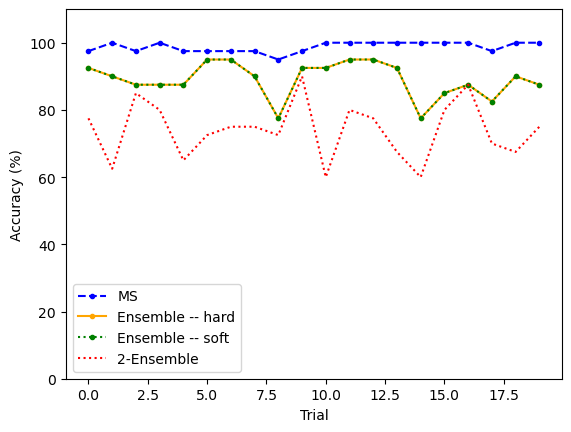

Accuracy Multiscale
99.0 ± 1.0

Accuracy GW Ensemble -- Hard
89.0 ± 5.0

Accuracy GW Ensemble -- Soft
89.0 ± 5.0

Accuracy individual GWs
74.0 ± 8.0

-----------------------------
Neighbors: 3
-----------------------------
Accuracy of single scale GW:
50.50 ± 5.68
98.25 ± 2.11
99.38 ± 1.34
57.62 ± 8.23
51.12 ± 5.56


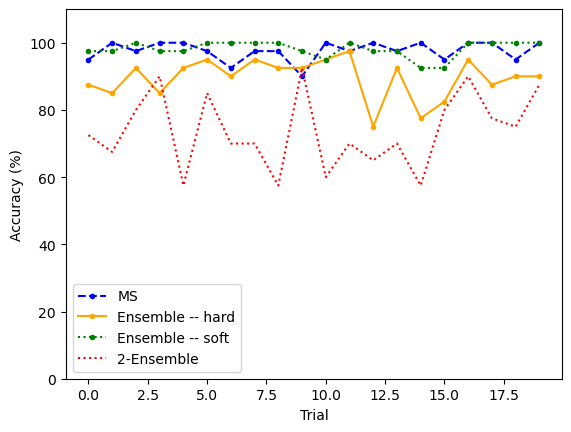

Accuracy Multiscale
98.0 ± 3.0

Accuracy GW Ensemble -- Hard
90.0 ± 6.0

Accuracy GW Ensemble -- Soft
98.0 ± 2.0

Accuracy individual GWs
74.0 ± 11.0



In [18]:
for idn, n_neighbors in enumerate(n_neighbor_list):
    print("-----------------------------")
    print(f"Neighbors: {n_neighbors}")
    print("-----------------------------")

    # GW classifiers
    print("Accuracy of single scale GW:")
    mean_accuracies = accuracies[idn].mean(axis=0)
    std_accuracies = accuracies[idn].std(axis=0)
    for t in range(nSteps):
        print(f"{mean_accuracies[t]:.2f} ± {std_accuracies[t]:.2f}")

    # Plot accuracies across trials
    plt.plot(accuracies_ms[idn, :], linestyle="dashed", color="blue", marker=".")
    plt.plot(accuracies_hard[idn, :], linestyle="solid", color="orange", marker=".")
    plt.plot(accuracies_soft[idn, :], linestyle="dotted", color="green", marker=".")

    plt.plot(accuracies_2[idn, :], linestyle="dotted", color="red")
    plt.xlabel("Trial")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 110)

    plt.legend(["MS", "Ensemble -- hard", "Ensemble -- soft", "2-Ensemble"])
    plt.show()

    # Show mean accuracy of each method
    print("Accuracy Multiscale")
    print(np.round(accuracies_ms[idn, :].mean(), 0), end="")
    print(" ± ", end="")
    print(np.round(accuracies_ms[idn, :].std(), 0))
    print()

    print("Accuracy GW Ensemble -- Hard")
    print(np.round(accuracies_hard[idn, :].mean(), 0), end="")
    print(" ± ", end="")
    print(np.round(accuracies_hard[idn, :].std(), 0))
    print()

    print("Accuracy GW Ensemble -- Soft")
    print(np.round(accuracies_soft[idn, :].mean(), 0), end="")
    print(" ± ", end="")
    print(np.round(accuracies_soft[idn, :].std(), 0))
    print()

    print("Accuracy individual GWs")
    print(np.round(accuracies_2[idn, :].mean(), 0), end="")
    print(" ± ", end="")
    print(np.round(accuracies_2[idn, :].std(), 0))
    print()